# R-CNN Implementation

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import cv2
import torchvision

## Dataset preparing

Fine-tuning : VOC 2012 train set

SVM         : VOC 2012 trainval set

Test        : VOC 2007 trainval set

In [3]:
train_data_finetuning = VOCDetection(root='data/finetuning',
                                     year='2012',
                                     image_set='train',
                                     download=False)

train_data_SVM = VOCDetection(root='data/SVM',
                              year='2012',
                              image_set='trainval',
                              download=False)

test_data = VOCDetection(root='data/test',
                         year='2007',
                         image_set='trainval',
                         download=False)

## Region Proposals

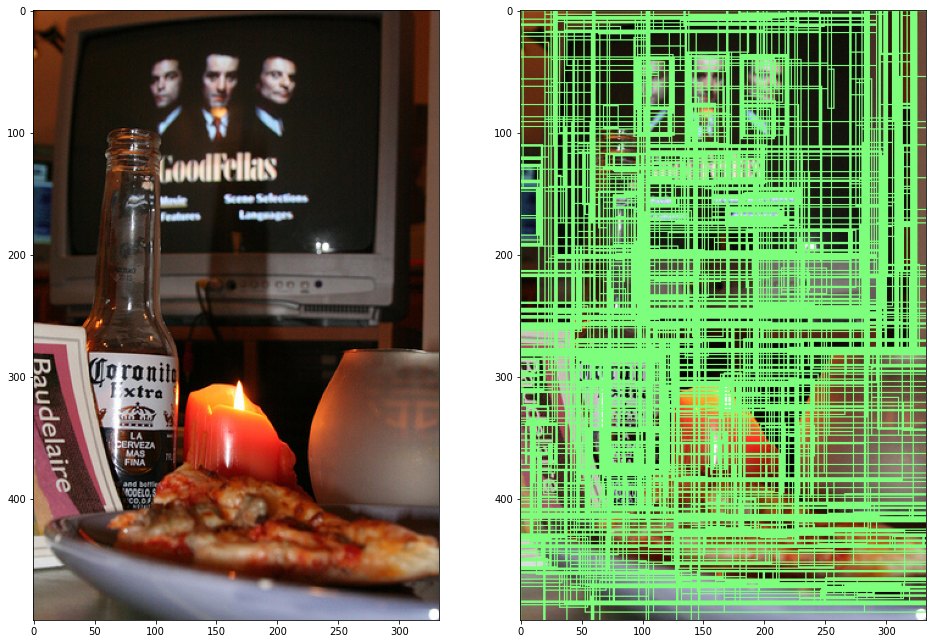

In [4]:
src, trg = train_data_finetuning[3]

src = np.array(src)
fig = plt.figure(figsize=(16,16))

# OpenCV는 BGR 색공간 기준, 기존 data는 RGB 환경
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

#################################################################
output = src.copy()
src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)

ss.setBaseImage(src)
ss.switchToSelectiveSearchFast()
rois = ss.process()

color = (125, 255, 125)
for roi in rois:
    x, y, w, h = roi
    cv2.rectangle(output, (x,y), (x+w,y+h), color, 1)

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(output)
plt.show()
#################################################################

In [5]:
def region_proposal(ss, src):
    """_summary_

    Args:
        ss (Module): SelectiveSearch module
        src (2D ndarray, RGB): input image, RGB 2D ndarray

    Returns:
        rois (2D ndarray): (N x 4), N is num_rois and 4 means coordinates of roi (x, y, width, height)
    """
    src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)
    ss.setBaseImage(src)
    ss.switchToSelectiveSearchFast()
    rois = ss.process()
    return rois

In [23]:
def ft_labeling(root, dataset, num_samples, threshold, classes):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    columns = ['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    
    pos_csv = pd.DataFrame(columns=columns)
    neg_csv = pd.DataFrame(columns=columns)
    
    for i, (src, trg) in enumerate(dataset):
        if i >= num_samples:
            break
        
        filename = []
        gt_label = []
        gt_rois = []   
        for object in trg['annotation']['object']:
            gt_label.append(classes[object['name']])
            gt_rois.append(tuple(map(int, tuple(object['bndbox'].values()))))

        src = np.array(src)
        rois = torch.tensor(region_proposal(ss, src))
        # SS에 의해 구해진 rois coord는 x,y,w,h임.
        # xmin, ymin, xmax, ymax로 변경
        rois[:,2].add_(rois[:,0])
        rois[:,3].add_(rois[:,1])
        gt_rois = torch.tensor(gt_rois)
        gt_label = torch.tensor(gt_label)
        
        ious = torchvision.ops.box_iou(rois, gt_rois)
        
        #################################################################################
        ############################## Finetuning Labeling ##############################
        #################################################################################
        mask = (ious > threshold)
        
        positive_indices = mask.nonzero()
        negative_indices = torch.sum(mask, dim=1).sub_(1).nonzero()

        positive_rois = rois[positive_indices[:,0]]
        negative_rois = rois[negative_indices[:,0]]
        
        positive_labels = gt_label[positive_indices[:,1]].unsqueeze(1)
        negative_labels = torch.zeros(negative_indices.shape[0]).unsqueeze(1)
        
        pos_tmp = pd.DataFrame(torch.cat((positive_labels, positive_rois), dim=1).int().numpy(), columns=columns[1:])
        neg_tmp = pd.DataFrame(torch.cat((negative_labels, negative_rois), dim=1).int().numpy(), columns=columns[1:])
        filename = trg['annotation']['filename']
        pos_tmp.insert(0, "filename", filename)
        neg_tmp.insert(0, "filename", filename)
        
        pos_csv = pd.concat([pos_csv, pos_tmp], ignore_index=True)
        neg_csv = pd.concat([neg_csv, neg_tmp], ignore_index=True)
        
        pos_csv.to_csv(os.path.join(root, 'ft_positive.csv'), mode='w')
        neg_csv.to_csv(os.path.join(root, 'ft_negative.csv'), mode='w')

In [7]:
from PIL import Image

class FineTuningDataset(Dataset):
    def __init__(self, root, csv_file, classes, transform=None):
        self.csv_file = pd.read_csv(os.path.join(root, csv_file))
        self.root = root
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        filename = self.csv_file.iloc[idx, 1]
        bndbox = tuple(self.csv_file.iloc[idx, 3:7])
        img = Image.open(os.path.join(self.root, filename)).crop(bndbox).convert('RGB').resize((224, 224), Image.NEAREST)
        trg = torch.zeros(len(self.classes))
        trg[self.csv_file.iloc[idx, 2]] = 1
        
        if self.transform:
            src = self.transform(img)
        
        return src, trg  

In [24]:
classes_str = {
    'background':0,
    'aeroplane':1,
    'bicycle':2,
    'bird':3,
    'boat':4,
    'bottle':5,
    'bus':6,
    'car':7,
    'cat':8,
    'chair':9,
    'cow':10,
    'diningtable':11,
    'dog':12,
    'horse':13,
    'motorbike':14,
    'person':15,
    'pottedplant':16,
    'sheep':17,
    'sofa':18,
    'train':19,
    'tvmonitor':20
}
classes_int = dict((y,x) for x,y in classes_str.items())

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

root = 'data/finetuning/VOCdevkit/VOC2012/JPEGImages'

ft_labeling(root=root, dataset=train_data_finetuning, num_samples=15, threshold=0.5, classes=classes_str)

In [ ]:
num_epochs = 2
batch_size = 16
positive_size = batch_size // 4
negative_size = batch_size // 4 * 3

model = models.mobilenet_v2(pretrained=True).to(device)

model.classifier[1] = nn.Linear(model.last_channel, len(classes_str))

ft_positive_dataset = FineTuningDataset(root, 'positive.csv', classes_int, transforms.ToTensor())
ft_negative_dataset = FineTuningDataset(root, 'negative.csv', classes_int, transforms.ToTensor())

ft_positive_dataloader = DataLoader(ft_positive_dataset, positive_size, shuffle=True, num_workers=1, drop_last=True)
ft_negative_dataloader = DataLoader(ft_negative_dataset, negative_size, shuffle=True, num_workers=1, drop_last=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=4e-3)

losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for batch_idx, ((pos_src, pos_trg), (neg_src, neg_trg)) in enumerate(zip(ft_positive_dataloader, ft_negative_dataloader)):
        src = torch.cat((pos_src, neg_src)).to(device)
        trg = torch.cat((pos_trg, neg_trg)).to(device)

        optimizer.zero_grad()

        output = model(src)
        _, preds = torch.max(output.data, 1)
        loss = criterion(output, trg)

        losses.append(loss.item())
        print(f"Batch: {batch_idx}, Loss:{loss.item()}")
        loss.backward()
        optimizer.step()

In [ ]:
torch.save(model.state_dict(), 'ft_model_state_dict')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(losses)
plt.show()

In [21]:
def svm_labeling(root, dataset, num_samples, threshold, classes):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    columns = ['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    
    pos_csv = pd.DataFrame(columns=columns)
    neg_csv = pd.DataFrame(columns=columns)
    
    for i, (src, trg) in enumerate(dataset):
        if i >= num_samples:
            break
        
        filename = []
        gt_label = []
        gt_rois = []   
        for object in trg['annotation']['object']:
            gt_label.append(classes[object['name']])
            gt_rois.append(tuple(map(int, tuple(object['bndbox'].values()))))

        src = np.array(src)
        rois = torch.tensor(region_proposal(ss, src))
        # SS에 의해 구해진 rois coord는 x,y,w,h임.
        # xmin, ymin, xmax, ymax로 변경
        rois[:,2].add_(rois[:,0])
        rois[:,3].add_(rois[:,1])
        gt_rois = torch.tensor(gt_rois)
        gt_label = torch.tensor(gt_label)
        
        ious = torchvision.ops.box_iou(rois, gt_rois)

        mask = (ious > threshold)
        
        negative_indices = torch.sum(mask, dim=1).sub_(1).nonzero()

        positive_rois = gt_rois
        negative_rois = rois[negative_indices[:,0]]
        
        positive_labels = gt_label.unsqueeze(1)
        negative_labels = torch.zeros(negative_indices.shape[0]).unsqueeze(1)
        
        pos_tmp = pd.DataFrame(torch.cat((positive_labels, positive_rois), dim=1).int().numpy(), columns=columns[1:])
        neg_tmp = pd.DataFrame(torch.cat((negative_labels, negative_rois), dim=1).int().numpy(), columns=columns[1:])
        filename = trg['annotation']['filename']
        pos_tmp.insert(0, "filename", filename)
        neg_tmp.insert(0, "filename", filename)
        
        pos_csv = pd.concat([pos_csv, pos_tmp], ignore_index=True)
        neg_csv = pd.concat([neg_csv, neg_tmp], ignore_index=True)
        
        pos_csv.to_csv(os.path.join(root, 'svm_positive.csv'), mode='w')
        neg_csv.to_csv(os.path.join(root, 'svm_negative.csv'), mode='w')

In [13]:
from PIL import Image

class SVMDataset(Dataset):
    def __init__(self, root, csv_file, classes, transform=None):
        self.csv_file = pd.read_csv(os.path.join(root, csv_file))
        self.root = root
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        filename = self.csv_file.iloc[idx, 1]
        bndbox = tuple(self.csv_file.iloc[idx,3:7])
        img = Image.open(os.path.join(self.root, filename)).crop(bndbox).convert('RGB').resize((224, 224), Image.NEAREST)
        trg = torch.zeros(len(self.classes))
        trg[self.classes.index(self.csv_file.iloc[idx, 2])] = 1
        
        if self.transform:
            src = self.transform(img)
        
        return src, trg

In [22]:
root = 'data/SVM/VOCdevkit/VOC2012/JPEGImages'

svm_labeling(root=root, dataset=train_data_SVM, num_samples=15, threshold=0.5, classes=classes_str)

In [95]:
num_epochs = 2
batch_size = 64
positive_size = batch_size // 4
negative_size = batch_size // 4 * 3

svm_positive_dataset = SVMDataset(root, 'svm_positive.csv', classes_int, transforms.ToTensor())
svm_negative_dataset = SVMDataset(root, 'svm_negative.csv', classes_int, transforms.ToTensor())

svm_positive_dataloader = DataLoader(svm_positive_dataset, positive_size, shuffle=True, num_workers=2, drop_last=True)
svm_negative_dataloader = DataLoader(svm_negative_dataset, negative_size, shuffle=True, num_workers=2, drop_last=True)

optimizer = torch.optim.SGD(model.parameters(), lr=4e-3)

svm_losses = []

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for batch_idx, ((pos_src, pos_trg), (neg_src, neg_trg)) in enumerate(zip(svm_positive_dataloader, svm_negative_dataloader)):
        src = torch.cat((pos_src, neg_src)).to(device)
        trg = torch.cat((pos_trg, neg_trg)).to(device)

        optimizer.zero_grad()

        output = model(src)
        loss = torch.mean(torch.clamp(1 - output * trg, min=0))
        svm_losses.append(loss.item())
        print(f"Batch: {batch_idx}, Loss:{loss.item()}")
        loss.backward()
        optimizer.step()

In [ ]:
torch.save(model.state_dict(), 'svm_model_state_dict')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(svm_losses)
plt.show()

In [3]:
model = torch.load('svm_model').to(device)
model.eval()

NameError: name 'device' is not defined

In [130]:
from tqdm import tqdm

green_rgb = (125, 255, 51)
img_rgb_copy = src.copy()


for rect in tqdm(rois):
    left = rect[0]
    top = rect[1]
    right = left + rect[2]
    bottom = top + rect[3]
    for inp in input:
        if inp.shape[0] != 0 and inp.shape[1] != 0:
            output = model(torch.Tensor(inp).unsqueeze(0).permute(0,3,1,2)).to(device)
            result = classes[output.argmax().item()]
            if result == 'person':
              img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)


plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_copy)
plt.show()

  1%|          | 2/225 [00:05<09:39,  2.60s/it]


KeyboardInterrupt: 